In [62]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import pandas as pd
from astroquery.vizier import Vizier
import astropy.units as u
from astropy.coordinates import SkyCoord


# First off, we load the gaia data into our variables down below



Vizier.ROW_LIMIT = 10000
Vizier(columns = ['pmRA', 'pmDE','BP-RP', 'Gmag', 'Plx', 'e_pmRA', 'e_pmDE', 'e_Plx'])
result = Vizier.query_region(SkyCoord.from_name('Pleiades'),
                                 radius=2*u.deg,
                                 catalog='I/345/gaia2',
                                 column_filters={'Plx': '5 .. 10', 'pmDE' : '22 00 .. 26 00'})

BP_RP = result['I/345/gaia2']['BP-RP']
gmag = result['I/345/gaia2']['Gmag']
plx = result['I/345/gaia2']['Plx']
pmRA = result['I/345/gaia2']['pmRA']
pmDE = result['I/345/gaia2']['pmDE']
dPC = (1/plx)*1000

rslt = result['I/345/gaia2']

Text(0, 0.5, 'Number of Objects')

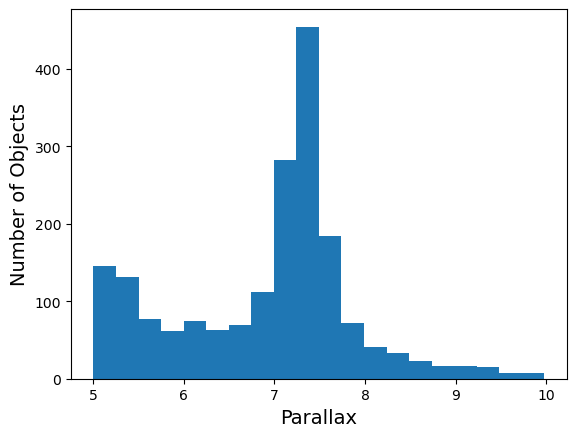

In [63]:
# This plots a histogram of the parallaxes of all teh objects from the catalog

plt.hist(plx, bins = 20)
plt.title
plt.xlabel('Parallax', fontsize = 14)
plt.ylabel('Number of Objects', fontsize = 14)

# We can already observe that there are more than one modes to this distribution

In [64]:
pmDE

-44.536
7.949
-47.879
-50.680
-18.923
-47.002
-212.969
-43.837
-44.055
...
12.253


-35.46939086563994

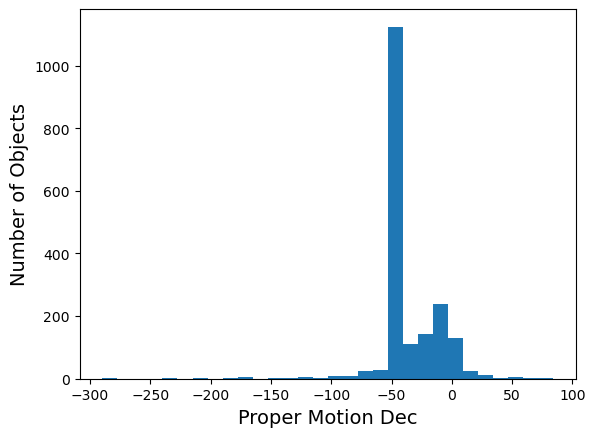

In [65]:
# This plots a histogram of the proper motions in declination of all the objects from the catalog

# We can also observe a bimodal distribution here. This causes our mean to be skewed from the mean of the cluster


plt.hist(pmDE, bins = 30)
plt.title
plt.xlabel('Proper Motion Dec', fontsize = 14)
plt.ylabel('Number of Objects', fontsize = 14)

np.mean(pmDE)

18.69425066383431

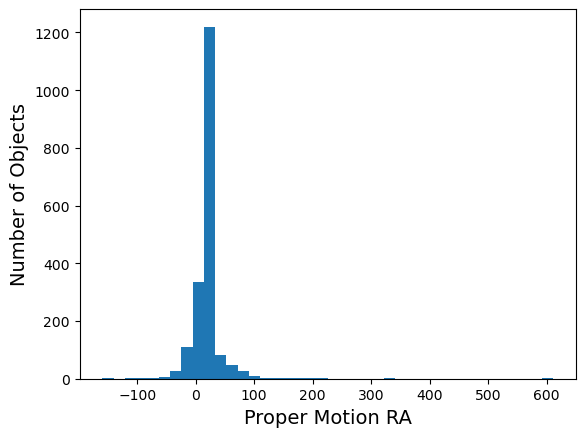

In [66]:
# This plots a histogram of the proper motions in RA of all the objects from the catalog

plt.hist(pmRA, bins = 40)
plt.title
plt.xlabel('Proper Motion RA', fontsize = 14)
plt.ylabel('Number of Objects', fontsize = 14)

np.mean(pmRA)

# Not exactly a gaussian... but the mean is closer to the actual value of the mean of the cluster

In [67]:
feats = [plx, pmDE]

In [68]:
feats = np.array(feats)
feats = np.flip(feats)      # Just accomodating data for the next step
feats = feats.T

In [69]:
feats = np.flip(feats)
feats

array([[  7.2306, -44.536 ],
       [  5.5484,   7.949 ],
       [  5.2316, -47.879 ],
       ...,
       [  6.3735, -38.935 ],
       [  9.8833, -49.135 ],
       [  7.8032, -46.81  ]])

In [70]:
feats = np.flip(feats)
feats

array([[-46.81  ,   7.8032],
       [-49.135 ,   9.8833],
       [-38.935 ,   6.3735],
       ...,
       [-47.879 ,   5.2316],
       [  7.949 ,   5.5484],
       [-44.536 ,   7.2306]])

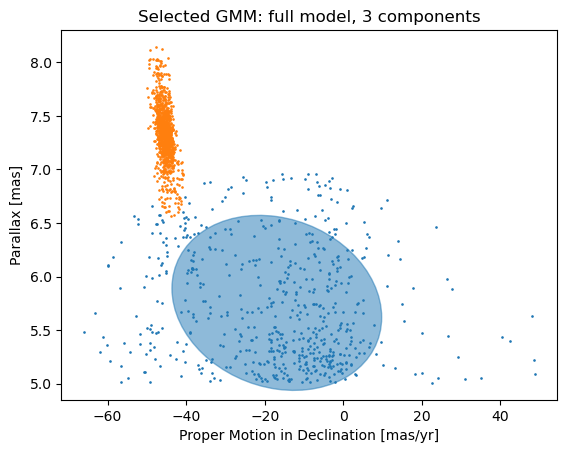

In [71]:
# This code is a clustering algorithm that will help us filter the data so we only work with the objects
# that correspond to the Pleiades. First, we test which type of covariance is most convenient, and the code will
# choose an algorithm to filter the data. We will work with parallax and proper motion in declination initially to 
# test it out and then go on to do it with RA and DE. These should give us approximately the same results though.

# More info on the code and algorithm used here:
    
# http://www-personal.umich.edu/~ognedin/gmm/gmm_user_guide.pdf
# https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html



from matplotlib.patches import Ellipse
from scipy import linalg
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import numpy as np

def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    return -estimator.bic(X)


param_grid = {
    "n_components": range(1, 7),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(feats)




color_iter = sns.color_palette("tab10", 2)[::-1]
Y_ = grid_search.predict(feats)

fig, ax = plt.subplots()

for i, (mean, cov, color) in enumerate(
    zip(
        grid_search.best_estimator_.means_,
        grid_search.best_estimator_.covariances_,
        color_iter,
    )
):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(feats[Y_ == i, 0], feats[Y_ == i, 1], 0.8, color=color)

    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ellipse = Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
    ellipse.set_clip_box(fig.bbox)
    ellipse.set_alpha(0.5)
    ax.add_artist(ellipse)

plt.title(
    f"Selected GMM: {grid_search.best_params_['covariance_type']} model, "
    f"{grid_search.best_params_['n_components']} components"
    
)

plt.ylabel('Parallax [mas]')
plt.xlabel('Proper Motion in Declination [mas/yr]')

plt.show()

# This plots the amount of clusters detected and shows two of them:

In [72]:
cov # covariant matrix of datasets.

array([[ 3.56849745e+02, -1.80775782e+00],
       [-1.80775782e+00,  3.33990615e-01]])

Text(0.5, 0, 'Proper Motion in Declination [mas/yr]')

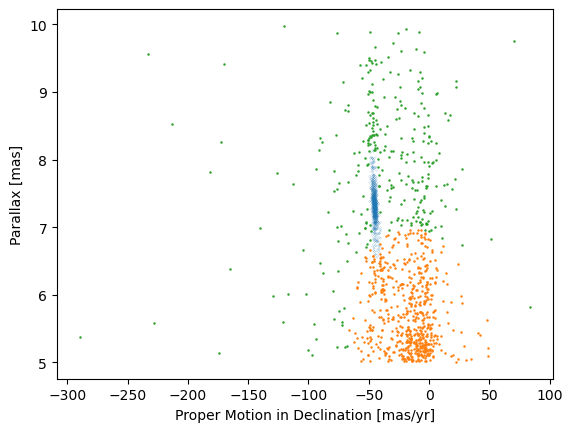

In [73]:
plt.scatter(feats[Y_[:] == 0, 0], feats[Y_[:] == 0, 1], s=0.01) # This is the right cluster corresponding to the Pleiades

plt.scatter(feats[Y_[:] == 1, 0], feats[Y_[:] == 1, 1], s=0.6)

plt.scatter(feats[Y_[:] == 2, 0], feats[Y_[:] == 2, 1], s=0.6)

plt.ylabel('Parallax [mas]')
plt.xlabel('Proper Motion in Declination [mas/yr]')

# Here's a plot with the 3 detected clusters, but most importantly, the cluster we were looking for (in blue)

In [74]:
feats2 = [pmRA, pmDE]
feats2 = np.array(feats2)
feats2 = np.flip(feats2)
feats2 = feats2.T
feats2



array([[-46.81 ,  20.37 ],
       [-49.135,  21.645],
       [-38.935,  17.705],
       ...,
       [-47.879,  32.232],
       [  7.949,  15.751],
       [-44.536,  20.136]])

Text(0.5, 1.0, 'Distribution of stars by pm')

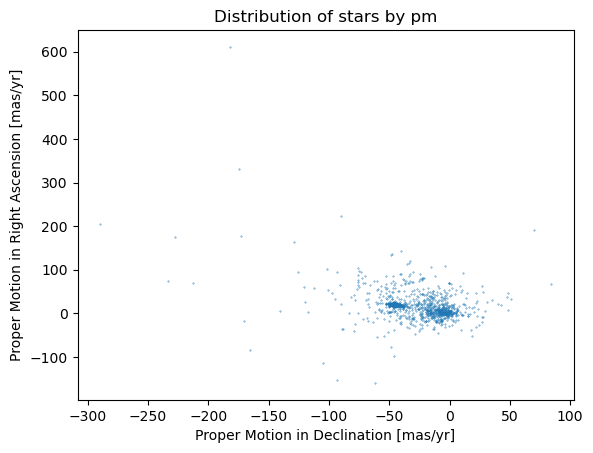

In [90]:
plt.scatter(pmDE, pmRA, s=0.1)
plt.ylabel('Proper Motion in Right Ascension [mas/yr]')
plt.xlabel('Proper Motion in Declination [mas/yr]')
plt.title("Distribution of stars by pm")

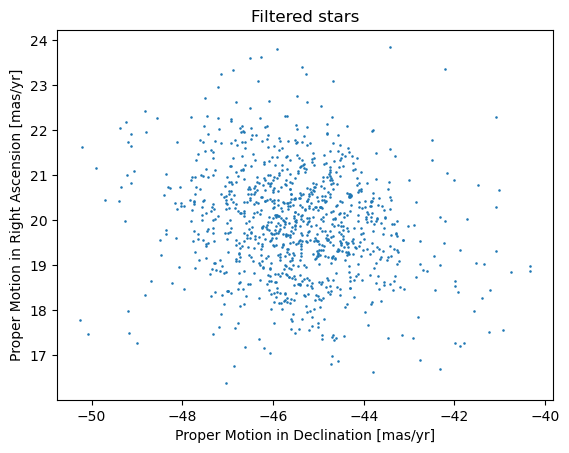

In [91]:
# Now, we can try using the model with the proper motions in DEC and RA
# to filter the data points that correspond to the cluster:




grid_search.fit(feats2)


color_iter = sns.color_palette("tab10", 2)[::-1]
Y_2 = grid_search.predict(feats2)

check = []
for i in range(grid_search.best_params_['n_components']):
    check.append(np.size(feats2[Y_2[:] == i, 0]))
m = np.argmax(check)
which = (Y_2 == m)

plt.scatter(feats2[which, 0], feats2[which, 1], s=0.7)
plt.title("Filtered stars")

plt.ylabel('Proper Motion in Right Ascension [mas/yr]')
plt.xlabel('Proper Motion in Declination [mas/yr]')

# This plots the filtered data points: 

plt.show()

In [77]:
which

array([ True,  True, False, ..., False, False,  True])

In [78]:
# now we use the filtered data to obtain the CM diagram:

gmagN = gmag[np.flip(which)]
BP_RPN = BP_RP[np.flip(which)]
pmDEN = pmDE[np.flip(which)]
pmRAN = pmRA[np.flip(which)]
plxN = plx[np.flip(which)]
dPCN = dPC[np.flip(which)]


np.mean(pmDEN) # Now we get the RIGHT mean proper motion in dec from the right mode of the 
                              # Pleiades cluster

-45.4873323699422

Text(0, 0.5, 'Gmag')

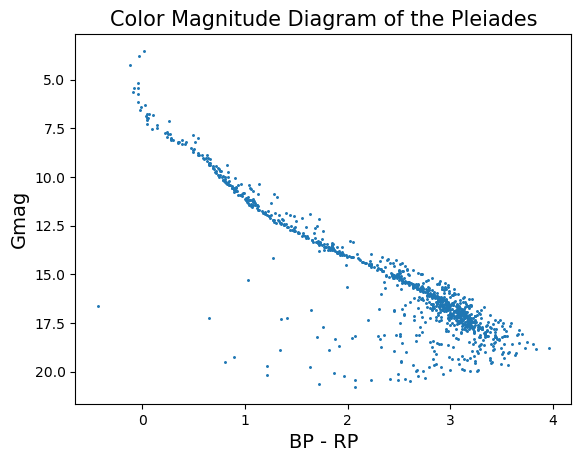

In [43]:

graph, (plot1) = plt.subplots(1)
plot1.scatter(BP_RPN, gmagN, marker=".", s= 5)
plot1.invert_yaxis()
plt.title('Color Magnitude Diagram of the Pleiades', loc='center', fontsize= 15)
plt.xlabel('BP - RP', fontsize = 14)
plt.ylabel('Gmag', fontsize = 14)

In [44]:
dat = np.genfromtxt('isochrones.txt', skip_header = 8, invalid_raise=False)
dat2 = np.genfromtxt('isochrones2.txt', skip_header = 8, invalid_raise=False)
dat3 = np.genfromtxt('isochrones3.txt', skip_header = 8, invalid_raise=False)



# Isochrones from CMD:

# The age of the isochrones came from: https://webda.physics.muni.cz/cgi-bin/ocl_page.cgi?dirname=mel022
# dat1 => age of 8.131 (in Logscale)
# dat2 => 10^8 
# dat3 => 10^10


dat.shape

(467, 31)

In [45]:
ISGmag1 = dat[:,27] + 5.5
ISBP_RP1 = dat[:,29]-dat[:,30]

ISGmag2 = dat2[:,27] + 5.5
ISBP_RP2 = dat2[:,29]-dat2[:,30]

ISGmag3 = dat3[:,27] + 5.5
ISBP_RP3 = dat3[:,29]-dat3[:,30]

# Correction of 5.5 mag 

In [46]:
ISGmag = np.flip(ISGmag)
ISBP_RP = np.flip(ISBP_RP)

NameError: name 'ISGmag' is not defined

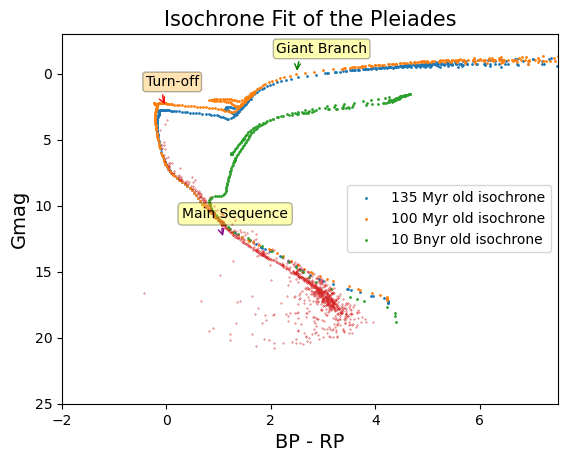

In [47]:
from adjustText import adjust_text

graph, (plot2) = plt.subplots(1)
plot2.scatter((ISBP_RP1), (ISGmag1), s=1, label='135 Myr old isochrone')
plot2.scatter((ISBP_RP2), (ISGmag2), s=1, label='100 Myr old isochrone')
plot2.scatter((ISBP_RP3), (ISGmag3), s=1, label='10 Bnyr old isochrone')
plot2.scatter(BP_RPN, gmagN, s=0.1)
plot2.invert_yaxis()
plt.title('Isochrone Fit of the Pleiades', loc='center', fontsize= 15)
plt.xlabel('BP - RP', fontsize = 14)
plt.ylabel('Gmag', fontsize = 14)
plot2.annotate('Turn-off', xy=(0, 2.5), xytext=(-15, 15),
            textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.2', fc='orange', alpha=0.3),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', 
                            color='red'))
plot2.annotate('Giant Branch', xy=(2.5, 0), xytext=(-15, 15),
            textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', 
                            color='green'))
plot2.annotate('Main Sequence', xy=(1.1, 12.5), xytext=(-30, 15),
            textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.3),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', 
                            color='purple'))

plot2.set_xlim(-2, 7.5)
plot2.set_ylim(25, -3)
plt.legend()
plt.show()


In [48]:
#WEBDA distance: 150 pc
#SIMBAD proper motion in DEC -45.548 mas/yr
#SIMBAD proper motion in DEC 19.997 mas/yr

#http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=Pleiades&submit=SIMBAD+search

#Distance:
print("Distance and error in parsecs: ", np.mean(dPCN), np.std(dPCN))
print("pm Declination and error in mas/year: ", np.mean(pmDEN), np.std(pmDEN))
print("pm RA and error in mas/year: ", np.mean(pmRAN), np.std(pmRAN))



Distance and error in parsecs:  136.39445999465846 7.06146560957806
pm Declination and error in mas/year:  -45.4873323699422 1.4922675999684434
pm RA and error in mas/year:  19.941688824662812 1.2866710300562825


In [49]:
# Sky Area of the cluster
mean = np.mean(plxN)
stdev = np.std(plxN)
ClustArea = np.pi* (stdev*2) **2
ClustArea

1.8876501554480498

In [83]:
clusRad = np.std(dPCN)*2.3555/2
clusRad

8.316641121680561

In [82]:
clusterArea = np.pi*(np.std(plxN)*2.3555/2)**2
clusterArea #in mas^2

0.6545875525873369

In [86]:
mea = np.mean(dPCN)

In [87]:
mea+clusRad, mea-clusRad

(144.71110111633902, 128.0778188729779)

In [89]:
np.std(plxN)

0.38757505922578517